In [1]:
import functools
import sys
import math
import scipy.io
sys.path.append("..")
import matplotlib.pyplot as plt
import numpy as np

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_probability as tfp

import Test_Likelihood as tl
import ODE_Dynamics as od
import Positive_Symptom_fn as fn

from functools import partial

import scipy.stats as ss

tfd = tfp.distributions
tfb = tfp.bijectors

In [2]:
# Load Data
data = scipy.io.loadmat('../data/test_data_simulation.mat')
x = tf.cast(data['data_simulation'],dtype = tf.float32)
full_data = np.reshape(
      x, x.shape)
full_data = tf.transpose(full_data)
start_day = 20
end_day = 30
sliced_data = full_data[start_day:end_day,:]
print(sliced_data)

tf.Tensor(
[[  20.  973.   13.]
 [  21. 1036.   10.]
 [  22. 1016.   18.]
 [  23. 1023.   11.]
 [  24. 1002.   16.]
 [  25. 1056.   21.]
 [  26.  994.   17.]
 [  27. 1115.   27.]
 [  28. 1010.   24.]
 [  29. 1020.   25.]], shape=(10, 3), dtype=float32)


In [3]:
# Arrange data in workable format
days = [float(i) for i in list(range(len(sliced_data)))]
tests = sliced_data[:,1]
positives = sliced_data[:,2]
test_data = np.column_stack((days, tests, positives))
test_data = tf.cast(test_data, dtype = tf.float32)
print(test_data)

tf.Tensor(
[[0.000e+00 9.730e+02 1.300e+01]
 [1.000e+00 1.036e+03 1.000e+01]
 [2.000e+00 1.016e+03 1.800e+01]
 [3.000e+00 1.023e+03 1.100e+01]
 [4.000e+00 1.002e+03 1.600e+01]
 [5.000e+00 1.056e+03 2.100e+01]
 [6.000e+00 9.940e+02 1.700e+01]
 [7.000e+00 1.115e+03 2.700e+01]
 [8.000e+00 1.010e+03 2.400e+01]
 [9.000e+00 1.020e+03 2.500e+01]], shape=(10, 3), dtype=float32)


In [4]:
vdyn_ode_fn = od.ViralDynamics
positive_fn = fn.proba_pos_sym(170306.4 * 1E-5).positive_fn
symptom_fn = fn.proba_pos_sym(170306.4 * 1E-5).symptom_fn
prob_s_ibar = 0.1
mu_b, sigma_b = 5, 1
beta = np.random.normal(mu_b, sigma_b, 1)
L = 0.0025/beta
V0 = 1E3
X0 = 1E6
Y0 = V0
par=tf.constant(np.array([[L,0.01,beta*1E-7,0.5,20,10, V0, X0, Y0]], dtype=np.float32))
vpar = par
pospar = par
sympar = par
sample_size = 1000
k = 1
index = 1
mu_b, sigma_b = 5, 1
beta = np.random.normal(mu_b, sigma_b, 1)   #"rate at which virus infects host cells"
L = 0.0025/beta
par=np.array([[L,0.01,beta*1E-7,0.5,20.0,10.0]])
V0 = np.random.normal(1E3, 1E2, 1)
X0 = 1E6
Y0 = V0
init_state=(np.array([[V0,X0,Y0]], dtype=np.float32))

while index <= sample_size - 1:
    beta = np.random.normal(mu_b, sigma_b, 1)   #"rate at which virus infects host cells"
    L = 0.0025/beta
    par_new=np.array([[L,0.01,beta*1E-7,0.5,20.0,10.0]])
    par = np.concatenate((par, par_new), axis = 0)
    V0 = np.random.normal(1E3, 1E2, 1)
    X0 = 1E6
    Y0 = V0
    init_state_new=(np.array([[V0,X0,Y0]], dtype=np.float32))
    init_state = np.concatenate((init_state, init_state_new), 0)

    index +=1
        

vpar = tf.constant(par, dtype=tf.float32)
pospar = par
sympar = par


In [5]:
# Joint prior on nu, i, s
# nu ~ Beta(2,8), so that mode = 0.1
# i, s, (1-i-s) ~ Dirichlet(0.1,0.1,0.1)

joint_prior = tfd.JointDistributionNamed(dict(
    recov_rate = tfd.Beta(2,8),
    epi_state = tfd.Dirichlet(
    concentration = np.ones(2, np.float32)/10),
))

In [6]:
# Joint log prior
def joint_log_prior(nu, i, s):
    epi_state = [i,s]
    return joint_prior.log_prob(
      recov_rate = nu, epi_state = epi_state)

In [7]:
# Joint log-likelihood
# Prior on R0: 1/R0

def joint_log_prob(test_data, R0, nu, i, s):
    
    epipar = tf.constant(np.array([[R0, 5.0E-08, nu, i, s]], dtype=np.float32))

    loglike = tl.loglik(test_data, vdyn_ode_fn, positive_fn, symptom_fn, prob_s_ibar, prob_fp=0.0, Epi_Model=od.SIR,
                 duration= 20.0, Epi_cadence=0.5, Vir_cadence=0.0625)
    ll,pp = loglike.__call__(test_data, epipar, vpar, pospar, sympar)
    ll = ll - math.log(R0) + joint_log_prior(nu,i,s).numpy()
    #+ math.log(ss.beta.pdf(nu,1,1))
    return ll


In [8]:
joint_log_prob(test_data, R0 = 1.8, nu = 0.1, i = 0.01, s = 0.9)

initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)


<tf.Tensor: shape=(), dtype=float32, numpy=-1555.501>

In [9]:
# Compute log_lik 
# Impute things we don't want to sample, eg. observations

unnormalized_posterior_log_prob = partial(joint_log_prob, test_data)


In [10]:
# Initialize parameters

r0 = 1.8; nu0 = 0.1; i0 = 0.015; s0 = 0.985
initial_state = [r0, nu0, i0, s0]

In [11]:
# Transform all parameters so that parameter spaces are unconstrained
# Every parameter needs a bijector, might be 'Identity'

unconstraining_bijectors = [
    tfb.Log(),
    tfb.Invert(tfb.Sigmoid()),
    tfb.Invert(tfb.Sigmoid()),
    tfb.Invert(tfb.Sigmoid())
]

In [12]:
n_sample = 3500
n_burnin = 3000
n_adaptation = 2400

In [13]:
#@tf.function(autograph=False)
def sample():
    return tfp.mcmc.sample_chain(
        num_results = n_sample,
        num_burnin_steps = n_burnin,
        current_state = initial_state,
        kernel = tfp.mcmc.SimpleStepSizeAdaptation(
            tfp.mcmc.TransformedTransitionKernel(
                inner_kernel = tfp.mcmc.HamiltonianMonteCarlo(
                    target_log_prob_fn = unnormalized_posterior_log_prob,
                     step_size = 0.001,
                     num_leapfrog_steps = 2),
                bijector = unconstraining_bijectors),
             num_adaptation_steps = n_adaptation),
        trace_fn=lambda _, pkr: pkr.inner_results.inner_results.is_accepted)

In [14]:
[R0, nu, i, s], is_accepted = sample()

initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=floa

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=floa

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=floa

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=floa

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=floa

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial time
tf.Tensor(-21.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
initial ti

In [15]:
# Compute posterior means of Epidemic parameters

acceptance_rate = tf.reduce_mean(tf.cast(is_accepted, dtype=tf.float32)).numpy()
mean_R0 = tf.reduce_mean(R0, axis=0).numpy()
mean_nu = tf.reduce_mean(nu, axis=0).numpy()
mean_i = tf.reduce_mean(i, axis=0).numpy()
mean_s = tf.reduce_mean(s, axis=0).numpy()


In [16]:
print('acceptance_rate:', acceptance_rate)
print('avg basic reproduction number:', mean_R0)
print('avg recovery rate:', mean_nu)
print('avg infected', mean_i)
print('avg susceptible', mean_s)

acceptance_rate: 0.54714286
avg basic reproduction number: 1.7966292
avg recovery rate: 0.09061847
avg infected 0.0019381745
avg susceptible 0.83190095


In [18]:
# Forecast Infection Rate, 7 Days into Future
forecast_window = 7
R0_sample = R0[n_burnin:n_sample]
nu_sample = nu[n_burnin:n_sample]
i_sample = i[n_burnin:n_sample]
s_sample = s[n_burnin:n_sample]

mod = od.SIR(par)

par=tf.constant(np.array([[R0_sample[1].numpy(), 5.0E-08, nu_sample[1].numpy()]], dtype=np.float32))
init_state=tf.constant(np.array([[i_sample[1].numpy(),s_sample[1].numpy()]], dtype=np.float32))
init_time=tf.constant(0.0)
int_duration = end_day - start_day + forecast_window
soln_times=tf.constant(np.linspace(0.0,int_duration,num=int_duration,dtype=np.float32))
dp = tfp.math.ode.DormandPrince()
results = dp.solve(mod.RHS, init_time, init_state, solution_times=soln_times)
i_forecast = results.states[:,0,0].numpy()


In [19]:
id = 1
while id < len(R0_sample):
    par=tf.constant(np.array([[R0_sample[id].numpy(), 5.0E-08, nu_sample[id].numpy()]], dtype=np.float32))
    init_state=tf.constant(np.array([[i_sample[id].numpy(),s_sample[id].numpy()]], dtype=np.float32))
    init_time=tf.constant(0.0)
    soln_times=tf.constant(np.linspace(0.0,int_duration,num=int_duration,dtype=np.float32))
    dp = tfp.math.ode.DormandPrince()
    results = dp.solve(mod.RHS, init_time, init_state, solution_times=soln_times)
    i_forecast = np.column_stack((i_forecast, results.states[:,0,0].numpy()))
    id += 1


In [20]:
i_forecast_lower = []
i_forecast_upper = []
i_forecast_median = []

for j in range(forecast_window):
    id = end_day - start_day + j
    i_forecast_lower.append(np.percentile(i_forecast[id], 5))
    i_forecast_upper.append(np.percentile(i_forecast[id], 95))
    i_forecast_median.append(np.percentile(i_forecast[id], 50))
    
print(i_forecast_lower)
print(i_forecast_upper)
print(i_forecast_median)

[0.0023266065400093794, 0.002443628152832389, 0.0025629603769630194, 0.0026850199792534113, 0.0028106574900448322, 0.002940701087936759, 0.0030758700449950993]
[0.003152362536638975, 0.0033103476744145155, 0.003470868803560734, 0.0036345499102026224, 0.0038026440888643265, 0.003975021652877331, 0.004150455351918936]
[0.0026849310379475355, 0.002818184206262231, 0.0029522713739424944, 0.0030888878973200917, 0.003229036694392562, 0.003373688319697976, 0.003524702275171876]


In [21]:
par=tf.constant(np.array([[1.8, 5.0E-08,0.1]], dtype=np.float32))
mod = od.SIR(par)
init_state=tf.constant(np.array([[0.001,0.999]], dtype=np.float32))
init_time=tf.constant(0.0)
soln_times=tf.constant(np.linspace(0.0,100.0,num=100,dtype=np.float32))
dp = tfp.math.ode.DormandPrince()
results = dp.solve(mod.RHS, init_time, init_state, solution_times=soln_times)
i_true = results.states[:,0,0].numpy()
t1 = end_day
t2 = end_day + 7
i_true = i_true[t1:t2]
print(i_true)

[0.01074404 0.01160208 0.01252336 0.01351156 0.01457044 0.01570388
 0.0169159 ]


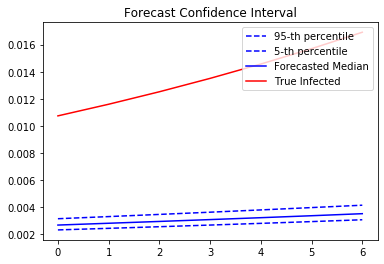

In [22]:
import matplotlib.pyplot as plt
t = list(range(len(i_forecast_median)))
plt.plot(t, i_forecast_lower, "b--",label = "95-th percentile")
plt.plot(t, i_forecast_upper,"b--",label = "5-th percentile")
plt.plot(t, i_forecast_median, "b-",label = "Forecasted Median")
plt.plot(t, i_true, "r-", label = "True Infected")
plt.title('Forecast Confidence Interval')
plt.legend(loc="upper right")
plt.savefig('Forecast.png', dpi=300, bbox_inches='tight')

In [31]:
# Staircase Plot

import matplotlib.pyplot as plt
import staircase as sc
inverse_data = np.column_stack((R0_sample.numpy(), nu_sample.numpy(), i_sample.numpy(), s_sample.numpy()))
figname = "mcmc_staircase.png"
ndim = 4
scales = [0,0,0,0]
scales[0] = (min(R0_sample),max(R0_sample))
scales[1] = (min(nu_sample),max(nu_sample))
scales[2] = (min(i_sample),max(i_sample))
scales[3] = (min(s_sample),max(s_sample))

bin_num = 10
axlabel = ["R0", "nu", "i", "s"]
#sc.staircase_plot(inverse_data, figname, hist_scalex, hist_scaley, bin_num, xtrue = [1,1,-2,-1,1])
sc.staircase_plot_simple(inverse_data, figname, ndim, scales, bin_num, axlabel)



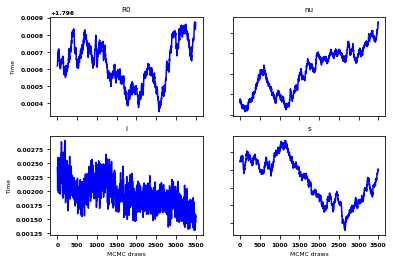

In [32]:
# Plot MCMC evolution

import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 2)
t = list(range(len(s)))
axs[0, 0].plot(t, R0.numpy(), "b-")
axs[0, 0].set_title('R0')
axs[0, 1].plot(t, nu.numpy(), "b-")
axs[0, 1].set_title('nu')
axs[1, 0].plot(t, i.numpy(), "b-")
axs[1, 0].set_title('i')
axs[1, 1].plot(t, s.numpy(), "b-")
axs[1, 1].set_title('s')

for ax in axs.flat:
    ax.set(xlabel='MCMC draws', ylabel='Time')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
plt.savefig('MCMC_runs.png', dpi=300, bbox_inches='tight')